In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 5)

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [3]:
import numpy as np
import librosa

from composition.instrument import Score, Part, Phrase, show
import composition.common as k
from utils import QuantileTransformer

* violin: mean: -43.36, std: 5.23
* viola: mean: -42.76, std: 7.77
* cello: mean: -57.26, std: 6.12
* flute: mean: -55.27, std: 8.37
* flute2: mean: -55.27, std: 8.37
- Violin 55-103
- Viola 48-91
- Cello 36-76
- Flute 60-96
- Flute2 55-91

In [4]:
def rescale2(a, mi, ma):
    norm = (a - a[0]) / (a[-1] - a[0])
    return norm * (ma - mi) + mi

In [5]:
def fractal(points, n=3):
    points = np.array(points)
    segments = points.copy()
    for _ in range(n):
        segments = np.concatenate([rescale2(points, f, s)[:-1] for f, s in zip(segments, segments[1:])])
        segments = np.concatenate((segments, points[-1:]))
    return segments

In [6]:
def to_delta(d):
    return d[1:] - d[:-1]

def from_delta(d):
    return np.concatenate([[0], np.cumsum(d)])

In [7]:
def fractal_bpc(values, delta_times, n=0):
    values = fractal(values, n)
    delta_times = to_delta(fractal(from_delta(delta_times), n))
    
    return k.bpc_floor(values, delta_times), delta_times

In [8]:
dur = 16

In [9]:
amps = k.triangle(dur, 4)
amps += np.random.normal(0, 0.05, len(amps))
amps = k.to_db_loudness(amps, 'violin', min_loudness=0.1)

In [10]:
chord = np.array([74, 78, 79, 83])
pitches = k.triangle(dur, 1.3)
pitches = k.rescale(pitches, min(chord)-0.5, max(chord)+0.5)
pitches = k.autotune_explicit(pitches, 0.90, chord)
vibrato = k.sinusoid(dur, 4, 0, 0.25)
pitches += vibrato
pitches += np.random.normal(0, 0.05, len(pitches))
pitches = librosa.hz_to_midi(librosa.midi_to_hz(pitches) + k.phasor(dur, 1/dur) * librosa.midi_to_hz(38))

In [11]:
def rescale(a, mi, ma):
    norm = (a - np.min(a)) / (np.max(a) - np.min(a))
    return norm * (ma - mi) + mi

In [50]:
ll = 6
seed_p = np.random.rand(ll)
seed_a = sorted(np.random.rand(ll-2))
seed_a = np.concatenate([[0], seed_a, [1]])

In [54]:
seed_p = np.array((0, 0.7, 0.3, 1.0))
seed_a = np.array((0, 0.375, 0.625, 1.))

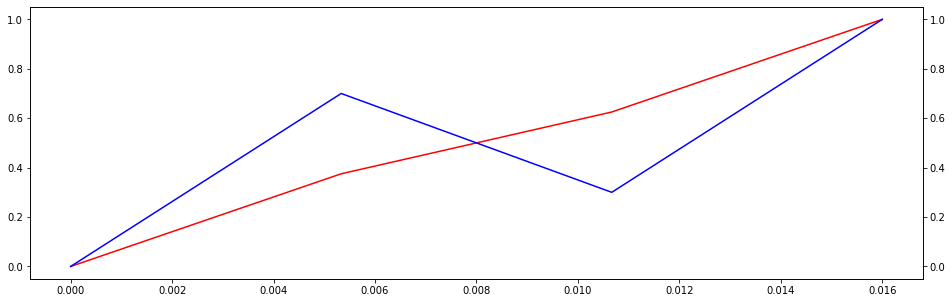

In [55]:
show(seed_p, seed_a)

In [92]:
vln1 = Part('Vln. 1', 'violin')
for i, dr in enumerate([2, 4, 8]):
    seed_d = to_delta(seed_a * dr)
    pitches, durs = fractal_bpc(seed_p, seed_d, i)
    pitches = np.pad(pitches, (0, k.time_to_step(dr) - len(pitches)), constant_values=pitches[-1])
    pitches = (pitches - min(pitches)) / (max(pitches) - min(pitches))
    pitches = k.rescale(pitches, 66, 66+12)
    # pitches = k.autotune(pitches, 0.95, list(np.random.randint(0, 11, 5)))
    pitches = k.autotune(pitches, 0.95)
    pitches += k.sinusoid(dr, 4, 0, 0.125)

    # amps = k.sinusoid(dr, 2/dr, -43.36, 5.23/2)
    amps = np.concatenate([k.triangle(d, 1/d, 0.01) for d in durs])
    # amps += np.random.normal(0, .5, len(amps))
    # amps = k.to_db_loudness(amps, 'violin', min_loudness=-0.1)
    amps = np.pad(amps, (0, k.time_to_step(dr) - len(amps)), constant_values=amps[-1])
    amps = rescale(amps, -55, -44)
    amps += k.line_segment(dr, -12, 4)
    
    vln1.add_phrase(Phrase(pitches, amps))
    vln1.add_phrase(Phrase(k.constant(1 + i, pitches[-1]), k.phasor(1+i, 1/(1+i)) * 9 - 55))

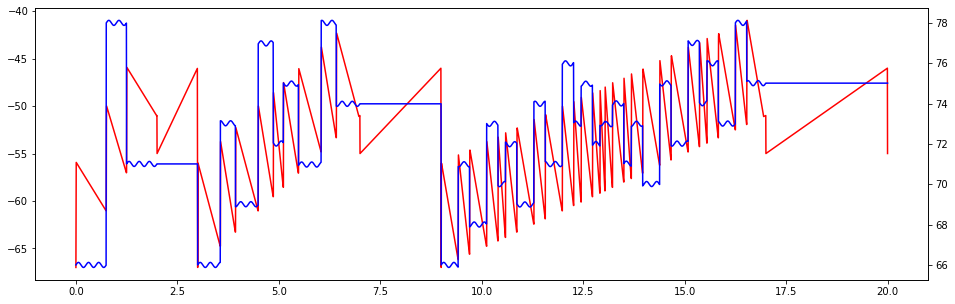

In [93]:
vln1.show()
vln1.play()

In [94]:
vln2 = Part('Vln. 2', 'violin')
for i, dr in enumerate([2, 4, 8]):
    seed_d = to_delta(seed_a * dr)
    pitches, durs = fractal_bpc(seed_p[::-1], np.roll(seed_d, 1), i)
    pitches = np.pad(pitches, (0, k.time_to_step(dr) - len(pitches)), constant_values=pitches[-1])
    pitches = (pitches - min(pitches)) / (max(pitches) - min(pitches))
    pitches = k.rescale(pitches, 61, 61+12)
    # pitches = k.autotune(pitches, 0.95, list(np.random.randint(0, 11, 5)))
    pitches = k.autotune(pitches, 0.95)
    pitches += k.sinusoid(dr, 4, 0, 0.125)

    # amps = k.sinusoid(dr, 2/dr, -43.36, 5.23/2)
    amps = np.concatenate([k.triangle(d, 1/d, 0.01) for d in durs])
    # amps += np.random.normal(0, .5, len(amps))
    # amps = k.to_db_loudness(amps, 'violin', min_loudness=-0.1)
    amps = np.pad(amps, (0, k.time_to_step(dr) - len(amps)), constant_values=amps[-1])
    amps = rescale(amps, -55, -44)
    amps += k.line_segment(dr, -12, 4)
    
    vln2.add_phrase(Phrase(pitches, amps))
    vln2.add_phrase(Phrase(k.constant(1 + i, pitches[-1]), k.phasor(1+i, 1/(1+i)) * 9 - 55))

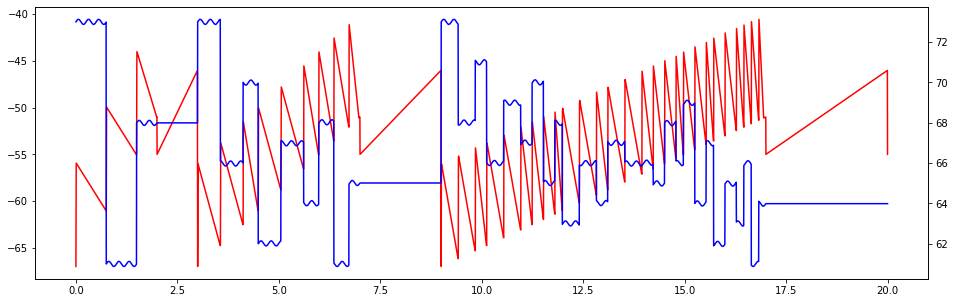

In [95]:
vln2.show()
vln2.play()

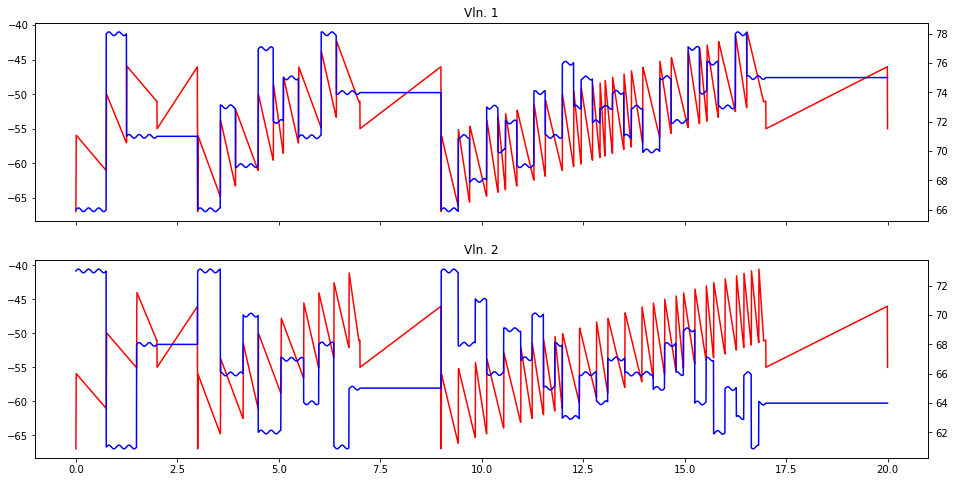

In [96]:
score = Score([vln1, vln2])
score.show()
score.play()

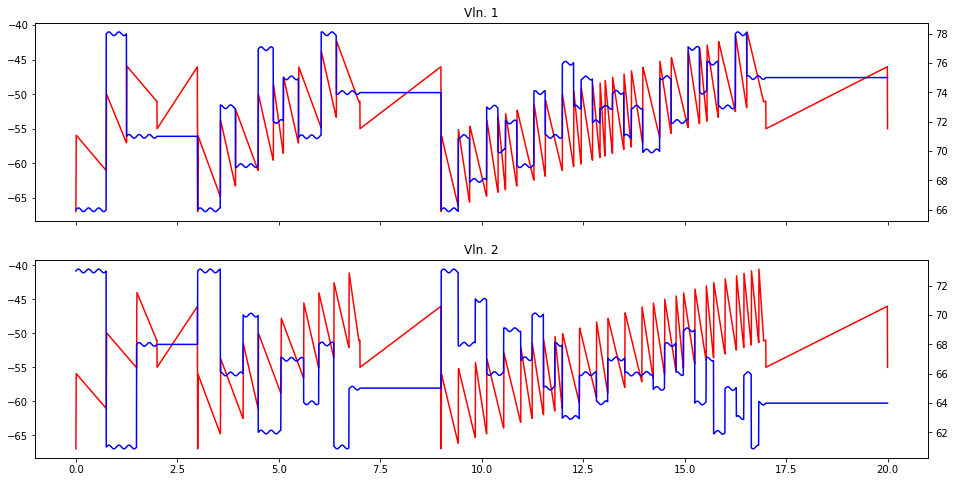

In [97]:
score.save('fractus-duo', './audio-data/december/')

In [ ]:
chord = np.array([74, 78, 79, 83]) + 4
pitches = k.triangle(dur, 0.8, phase=0.25)
pitches = k.rescale(pitches, min(chord)-0.5, max(chord)+0.5)
pitches = k.autotune_explicit(pitches, 0.90, chord)
vibrato = k.sinusoid(dur, 3.8, 0, 0.25, phase=0.3)
pitches += vibrato
pitches += np.random.normal(0, 0.05, len(pitches))

In [ ]:
amps = k.triangle(dur, 4, 0.25)
amps += np.random.normal(0, 0.05, len(amps))
amps = k.to_db_loudness(amps, 'violin', min_loudness=0.1)

In [ ]:
pitches, durs = fractal_bpc((0, 0.7, 0.2, 1), (6, 4, 6), 2)
pitches = np.pad(pitches, (0, k.time_to_step(dur) - len(pitches)), constant_values=pitches[-1])
pitches = (pitches - min(pitches)) / (max(pitches) - min(pitches))
pitches = k.rescale(pitches, 66-5, 66+24-5)
pitches = k.autotune(pitches, 0.9, 'melodic_minor')

In [ ]:
# amps = k.sinusoid(dur, 2/dur, -43.36, 5.23/2)
amps = np.concatenate([k.triangle(d, 1/d, 0.1) for d in durs])
# amps += np.random.normal(0, .5, len(amps))
# amps = k.to_db_loudness(amps, 'violin', min_loudness=-0.1)
amps = np.pad(amps, (0, k.time_to_step(dur) - len(amps)), constant_values=amps[-1])
amps **= 0.5
amps = rescale(amps, -50, -44)

In [ ]:
vln2 = Part('Vln. 2', 'violin')
vln2.add_phrase(Phrase(pitches, amps))

In [ ]:
vln2.show()
vln2.play()

In [ ]:
score = Score([vln1, vln2])
score.play()

In [ ]:
score.save('fractus', './audio-data/december/')

In [ ]:
chord = np.array([74, 78, 79, 83, 84, 88]) + 8
pitches = k.triangle(dur, 1, phase=1.2)
pitches = k.rescale(pitches, min(chord)-0.5, max(chord)+0.5)
pitches = k.autotune_explicit(pitches, 0.90, chord)
vibrato = k.sinusoid(dur, 3.8, 0, 0.25, phase=0.3)
pitches += vibrato
pitches += np.random.normal(0, 0.05, len(pitches))

In [ ]:
# amps = k.triangle(dur, 3.9, 0.25, phase=0.9)
amps = k.phasor(dur, 1/dur)
# amps += np.random.normal(0, 0.05, len(amps))
amps = k.to_db_loudness(amps, 'flute', min_loudness=-0.1)
amps += np.random.normal(0, 2.0, len(amps))

In [ ]:
flt1 = Part('Flt. 1', 'flute')
flt1.add_phrase(Phrase(pitches, amps))

In [ ]:
flt1.show()
flt1.play()

In [ ]:
chord = np.array([74, 78, 79, 83, 84, 88]) + 5
pitches = k.triangle(dur, 1.5, phase=1.9)
pitches = k.rescale(pitches, min(chord)-0.5, max(chord)+0.5)
pitches = k.autotune_explicit(pitches, 0.90, chord)
vibrato = k.sinusoid(dur, 3.8, 0, 0.25, phase=0.3)
pitches += vibrato
pitches += np.random.normal(0, 0.05, len(pitches))

In [ ]:
# amps = k.triangle(dur, 3.9, 0.25, phase=0.9)
amps = k.phasor(dur, 1/dur)
# amps += np.random.normal(0, 0.05, len(amps))
amps = k.to_db_loudness(amps, 'flute2', min_loudness=-0.1)
amps += np.random.normal(0, 2, len(amps))

In [ ]:
flt2 = Part('Flt. 2', 'flute2')
flt2.add_phrase(Phrase(pitches, amps))

In [ ]:
flt2.show()
flt2.play()

In [ ]:
pitches = k.constant(dur, 38)
vibrato = k.sinusoid(dur, 3.8, 0, 0.33, phase=0.3)
pitches += vibrato
pitches += np.random.normal(0, 0.05, len(pitches))

In [ ]:
amps = k.sinusoid(dur, 0.5/dur)
amps += np.random.normal(0, 0.01, len(amps))
amps = k.to_db_loudness(amps, 'cello', min_loudness=-0.1)
amps = np.clip(amps, -100, -40)

In [ ]:
vlc = Part('Vlc.', 'cello')
vlc.add_phrase(Phrase(pitches, amps))

In [ ]:
vlc.show()
vlc.play()

In [ ]:
score = Score([vln1, vln2, flt1, flt2, vlc])
score.show()
score.play()